In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from ImageDataset import *
from unet import *
from loss import *
import os
import zipfile
from helper import *
from tqdm import tqdm


## Unzip The Data  
Only if running on google colab


In [2]:

data_path = 'data.zip'

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()


In [3]:
TRAIN_IMAGES = 'data/training/images/'
GROUNDTRUTH = 'data/training/groundtruth/'
TEST_IMAGES = 'data/test_set_images/'
LOCAL_PREDICTIONS_PATH = 'local_predictions/'
PREDICTIONS_PATH= 'predictions/'
FOREGROUND_TRESHOLD = 0.25
SPLIT_RATIO = 0.1
BATCH_SIZE = 10
EPOCHS = 100
LR = 1e-3
SEED = 4
WEIGHT_DECAY = 1e-3
WORKERS = 2

In [4]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
pin_memory = device == 'cuda'

Device: cuda


In [5]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
dataset = ImagesDataset(
    img_dir=TRAIN_IMAGES,
    gt_dir=GROUNDTRUTH,
    image_transform=image_transform,
    mask_transform=mask_transform,
)

In [7]:
len(dataset)

100

In [9]:
image, mask = dataset[0]
print('Image size:', image.shape)
print('Mask size:', mask.shape)

Image size: torch.Size([3, 400, 400])
Mask size: torch.Size([1, 400, 400])


In [8]:
train_dataset, test_datset= split_data(dataset, 0.2, SEED)

### Don't Run this part it is the cross validation part

In [10]:
ratios= [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
datasets = [split_data(dataset, ratio, SEED) for ratio in ratios]

In [11]:
len(datasets)
len(datasets[0][0])

90

In [12]:
train_loaders= [DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=pin_memory) for train_dataset, test_dataset in datasets]

In [13]:
local_test_loaders= [DataLoader(test_dataset, num_workers=WORKERS, pin_memory=pin_memory) for train_dataset, test_dataset in datasets]

In [14]:
len(local_test_loaders[0].dataset)

10

In [15]:
len(train_loaders[0].dataset)

90

In [ ]:
"""
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)
"""

In [ ]:
"""
local_test_loader = DataLoader(
    dataset=test_datset,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)
"""

In [16]:
#model= UNet().to(device)
models= [UNet().to(device) for i in range(len(datasets))]

In [17]:
criterion = DiceLoss()
optimizers = [Adam(models[i].parameters(), lr=LR, weight_decay=WEIGHT_DECAY) for i in range(len(datasets))]

In [18]:
lr_schds= [ReduceLROnPlateau(optimizers[i], mode='min', patience=3, verbose=True) for i in range(len(datasets))]

In [ ]:
"""# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=3,
    verbose=True,
)
"""

In [9]:
def train(model, train_loader, criterion, optimizer, device, lr_scheduler=None):
    model.train()
    losses= list()
    # Training loop
    for epoch in range(EPOCHS):
        total_loss = 0.0
        # Iterate over the training data
        for data, target in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}', unit='batch'):
            # Send the input to the device
            data, target = data.to(device), target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the total loss
            total_loss += loss.item()

        # Average loss for the epoch
        average_loss = total_loss / len(train_loader)
        print(f"average loss: ", average_loss)
        losses.append((epoch,average_loss))

        # Adjust learning rate if a scheduler is provided
        if lr_scheduler is not None:
            lr_scheduler.step(average_loss)
    return losses

In [10]:
def predict(model, test_loader, device):
    model.eval()
    f1_scores = list()
    accuracy_scores = list()
    prediction_filnames = list()
    with torch.no_grad():
    # Loop over the dataset
        for i, (data, target) in enumerate(test_loader):
            filename = create_filename(len(test_loader),i)
            print(f'Processing {filename}')

            # Send the input to the device
            data = data.to(device)
            # Make the predictions
            output = model(data)

            # Get labels
            output = get_label(output, FOREGROUND_TRESHOLD)

            if target.dim() != 1:
                target= target.to(device)
                target = get_label(target, FOREGROUND_TRESHOLD)
                accuracy = accuracy_(target, output)
                f1 = f1_(target, output)
                accuracy_scores.append(accuracy)
                f1_scores.append(f1)

            # Save mask
            else:
                if not os.path.exists(PREDICTIONS_PATH):
                    os.makedirs(PREDICTIONS_PATH)
                output_path = os.path.join(PREDICTIONS_PATH, filename)
                save_prediction(output, output_path)
                prediction_filnames.append(output_path)

    # Print a message after processing all images
    print('Prediction completed.')

    # Print a message after processing all images
    if target.dim() != 1:
        avg_accuracy = sum(accuracy_scores).item() / len(accuracy_scores)
        avg_f1 = sum(f1_scores).item() / len(f1_scores)
        print('F1 Score: ', avg_f1)
        print('Accuracy: ', avg_accuracy)
        return avg_f1, avg_accuracy, prediction_filnames
    else:
        print("accuracy and f1 not computed")
        return None, None,prediction_filnames



In [ ]:
models_loss= list()
modeles_metrics= list()
for i in range(len(datasets)):
    print(f"Training model {i}")
    losses = train(models[i], train_loaders[i], criterion, optimizers[i], device, lr_schds[i])
    models_loss.append(losses)
    print(f"Predicting model {i}")
    metric= predict(models[i], local_test_loaders[i], device)
    modeles_metrics.append(metric)

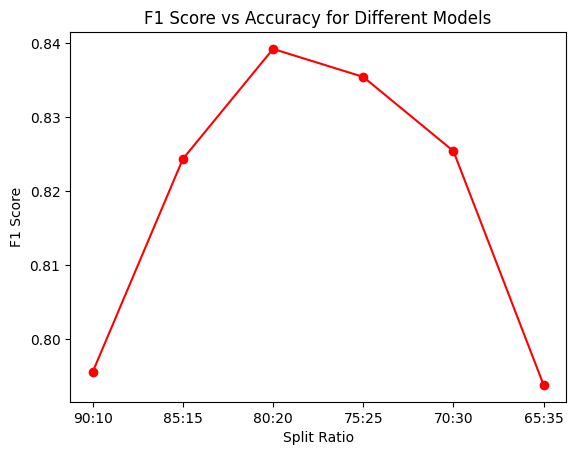

In [31]:
import matplotlib.pyplot as plt

f1_scores = [item[0] for item in modeles_metrics]
#accuracies = [item[1] for item in modeles_metrics]
m=['90:10', '85:15', '80:20', '75:25', '70:30', '65:35']

plt.plot(m, f1_scores, color='red', linestyle='-', marker= 'o')
plt.title('F1 Score vs Accuracy for Different Models')
plt.xlabel('Split Ratio')
plt.ylabel('F1 Score')
plt.show()

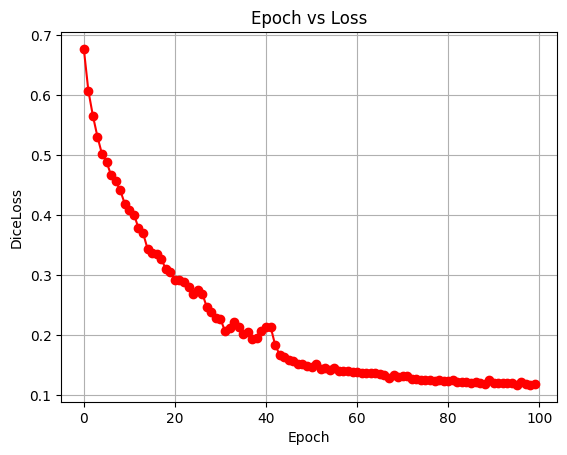

In [40]:
chosen_model= models_loss[2]
epochs = [item[0] for item in chosen_model]
losses = [item[1] for item in chosen_model]

# Plotting
plt.plot(epochs, losses, color='red', marker='o', linestyle='-')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('DiceLoss')
plt.grid(True)
plt.show()


## Training with Augmented Data

In [16]:
def create_augmented_dataset(trainingPath,gtPath,imgAugPath,gtAugPath,rotation_angles= [45,135,225]):

    # Creates directories
    for dirname in (imgAugPath, gtAugPath):
        os.makedirs(dirname, exist_ok=True)
    # Load the original dataset
    images = sorted(os.listdir(trainingPath))
    masks = sorted(os.listdir(gtPath))
    #Select the first 10 images
    for i in range(10):
      for angle in rotation_angles:

        # Get image and mask names
        image_name = images[i]
        mask_name = masks[i]

        # Get images paths
        image_path = os.path.join(trainingPath, image_name)
        mask_path = os.path.join(gtPath, mask_name)

        # Open images
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        to_tensor = transforms.ToTensor()

        #apply the transformations
        image_transformed = transforms.functional.affine(to_tensor(image), angle=angle,translate=(0, 0), scale=1.0, shear=0.0)
        mask_transformed = transforms.functional.affine(to_tensor(mask), angle=angle,translate=(0, 0), scale=1.0, shear=0.0)

        # Convert tensors to PIL Images
        image_transformed_PIL = transforms.ToPILImage()(image_transformed)
        mask_transformed_PIL = transforms.ToPILImage()(mask_transformed)

        # Save augmented dataset
        filename_img = f'Image_{i+1:04d}_{angle:03d}.png'
        filename_gd = f'gdImage_{i+1:04d}_{angle:03d}.png'

        image_path_aug = os.path.join(imgAugPath, filename_img)
        mask_path_aug = os.path.join(gtAugPath, filename_gd)

        image_transformed_PIL.save(image_path_aug)
        mask_transformed_PIL.save(mask_path_aug)

In [ ]:
create_augmented_dataset(TRAIN_IMAGES,GROUNDTRUTH,'data/Augmented/Images','data/Augmented/Groundtruth')

In [18]:
train_dataset2 = ImagesDataset(
    img_dir='data/Augmented/Images',
    gt_dir='data/Augmented/Groundtruth',
    image_transform=image_transform,
    mask_transform=mask_transform,
)

In [19]:
len(train_dataset2)

30

In [21]:
from torch.utils.data import Dataset, ConcatDataset
augmented_dataset= ConcatDataset([train_dataset, train_dataset2])

In [22]:
len(augmented_dataset)

110

In [23]:
train_loader_aug= DataLoader(augmented_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=pin_memory)

In [33]:
local_test_loader= DataLoader(test_datset,num_workers=WORKERS,pin_memory=pin_memory)

In [25]:
model= UNet().to(device)

In [28]:
criterion = DiceLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [29]:
lr_scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=3,
    verbose=True,
)

In [30]:
losses= train(model, train_loader_aug, criterion, optimizer, device, lr_scheduler)

Epoch 1/100: 100%|██████████| 11/11 [00:07<00:00,  1.48batch/s]


average loss:  0.6403764215382662


Epoch 2/100: 100%|██████████| 11/11 [00:05<00:00,  1.87batch/s]


average loss:  0.5688942670822144


Epoch 3/100: 100%|██████████| 11/11 [00:05<00:00,  1.91batch/s]


average loss:  0.5322423902424899


Epoch 4/100: 100%|██████████| 11/11 [00:05<00:00,  1.88batch/s]


average loss:  0.5090845823287964


Epoch 5/100: 100%|██████████| 11/11 [00:05<00:00,  1.88batch/s]


average loss:  0.4859243793921037


Epoch 6/100: 100%|██████████| 11/11 [00:05<00:00,  1.86batch/s]


average loss:  0.4645668755878102


Epoch 7/100: 100%|██████████| 11/11 [00:05<00:00,  1.86batch/s]


average loss:  0.4529620679942044


Epoch 8/100: 100%|██████████| 11/11 [00:06<00:00,  1.83batch/s]


average loss:  0.4186289364641363


Epoch 9/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.40757739543914795


Epoch 10/100: 100%|██████████| 11/11 [00:06<00:00,  1.82batch/s]


average loss:  0.41395312547683716


Epoch 11/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.3962154876102101


Epoch 12/100: 100%|██████████| 11/11 [00:06<00:00,  1.81batch/s]


average loss:  0.382445752620697


Epoch 13/100: 100%|██████████| 11/11 [00:06<00:00,  1.76batch/s]


average loss:  0.3630287918177518


Epoch 14/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.3412781845439564


Epoch 15/100: 100%|██████████| 11/11 [00:06<00:00,  1.74batch/s]


average loss:  0.34025198221206665


Epoch 16/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.3374612168832259


Epoch 17/100: 100%|██████████| 11/11 [00:06<00:00,  1.74batch/s]


average loss:  0.31588990038091486


Epoch 18/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.3135197433558377


Epoch 19/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.3086329427632419


Epoch 20/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.30178439075296576


Epoch 21/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.2984645529226823


Epoch 22/100: 100%|██████████| 11/11 [00:06<00:00,  1.80batch/s]


average loss:  0.30109901319850574


Epoch 23/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.28534089435230603


Epoch 24/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.2719393047419461


Epoch 25/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.2512242685664784


Epoch 26/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.25038735433058307


Epoch 27/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.24023336172103882


Epoch 28/100: 100%|██████████| 11/11 [00:06<00:00,  1.73batch/s]


average loss:  0.24709898775274103


Epoch 29/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.2527510848912326


Epoch 30/100: 100%|██████████| 11/11 [00:06<00:00,  1.76batch/s]


average loss:  0.24658767201683737


Epoch 31/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.2340659499168396


Epoch 32/100: 100%|██████████| 11/11 [00:06<00:00,  1.71batch/s]


average loss:  0.22020196372812445


Epoch 33/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.23014821789481424


Epoch 34/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.23283845728093927


Epoch 35/100: 100%|██████████| 11/11 [00:06<00:00,  1.80batch/s]


average loss:  0.21706498752940784


Epoch 36/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.22167891805822199


Epoch 37/100: 100%|██████████| 11/11 [00:06<00:00,  1.80batch/s]


average loss:  0.22974572398445822


Epoch 38/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.224641198461706


Epoch 39/100: 100%|██████████| 11/11 [00:06<00:00,  1.80batch/s]


average loss:  0.2248501398346641
Epoch 00039: reducing learning rate of group 0 to 1.0000e-04.


Epoch 40/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.2220613252032887


Epoch 41/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.1915726986798373


Epoch 42/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.189675358208743


Epoch 43/100: 100%|██████████| 11/11 [00:06<00:00,  1.76batch/s]


average loss:  0.18636630881916394


Epoch 44/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.17961219224062833


Epoch 45/100: 100%|██████████| 11/11 [00:06<00:00,  1.75batch/s]


average loss:  0.17390077764337714


Epoch 46/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.1747889518737793


Epoch 47/100: 100%|██████████| 11/11 [00:06<00:00,  1.75batch/s]


average loss:  0.17328021743080832


Epoch 48/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.17090363935990768


Epoch 49/100: 100%|██████████| 11/11 [00:06<00:00,  1.73batch/s]


average loss:  0.16877872293645685


Epoch 50/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.16935198957269842


Epoch 51/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.16723647984591397


Epoch 52/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.16981041973287408


Epoch 53/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.16144038872285324


Epoch 54/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.1659576025876132


Epoch 55/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.16278717734596945


Epoch 56/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.16012728756124323


Epoch 57/100: 100%|██████████| 11/11 [00:06<00:00,  1.70batch/s]


average loss:  0.16209582848982376


Epoch 58/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.1599547483704307


Epoch 59/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.16029022498564285


Epoch 60/100: 100%|██████████| 11/11 [00:06<00:00,  1.73batch/s]


average loss:  0.15723387219689108


Epoch 61/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.15647060762752185


Epoch 62/100: 100%|██████████| 11/11 [00:06<00:00,  1.72batch/s]


average loss:  0.15550884875384244


Epoch 63/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.15195488929748535


Epoch 64/100: 100%|██████████| 11/11 [00:06<00:00,  1.72batch/s]


average loss:  0.15636250105771152


Epoch 65/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.1539686159654097


Epoch 66/100: 100%|██████████| 11/11 [00:06<00:00,  1.71batch/s]


average loss:  0.15550805221904407


Epoch 67/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.15423836491324686
Epoch 00067: reducing learning rate of group 0 to 1.0000e-05.


Epoch 68/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.14908594434911554


Epoch 69/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.1460588574409485


Epoch 70/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.14661007577722723


Epoch 71/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.14629174904389816


Epoch 72/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.14718206904151224


Epoch 73/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.14463294636119495


Epoch 74/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.14435057206587357


Epoch 75/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.14321368932724


Epoch 76/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.1406445178118619


Epoch 77/100: 100%|██████████| 11/11 [00:06<00:00,  1.72batch/s]


average loss:  0.14367972720753064


Epoch 78/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.14337191798470236


Epoch 79/100: 100%|██████████| 11/11 [00:06<00:00,  1.75batch/s]


average loss:  0.1407616842876781


Epoch 80/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.14224717833779074
Epoch 00080: reducing learning rate of group 0 to 1.0000e-06.


Epoch 81/100: 100%|██████████| 11/11 [00:06<00:00,  1.72batch/s]


average loss:  0.14323980158025568


Epoch 82/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.14214848388325085


Epoch 83/100: 100%|██████████| 11/11 [00:06<00:00,  1.76batch/s]


average loss:  0.1411650451746854


Epoch 84/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.13974650339646774


Epoch 85/100: 100%|██████████| 11/11 [00:06<00:00,  1.76batch/s]


average loss:  0.1417460170659152


Epoch 86/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.1413408572023565


Epoch 87/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.1410825794393366


Epoch 88/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.14004164934158325
Epoch 00088: reducing learning rate of group 0 to 1.0000e-07.


Epoch 89/100: 100%|██████████| 11/11 [00:06<00:00,  1.75batch/s]


average loss:  0.14017778635025024


Epoch 90/100: 100%|██████████| 11/11 [00:06<00:00,  1.68batch/s]


average loss:  0.13897197354923596


Epoch 91/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.13935757767070422


Epoch 92/100: 100%|██████████| 11/11 [00:06<00:00,  1.74batch/s]


average loss:  0.13996759869835593


Epoch 93/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.14014564860950818


Epoch 94/100: 100%|██████████| 11/11 [00:06<00:00,  1.73batch/s]


average loss:  0.1386507207697088


Epoch 95/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.13923079859126697


Epoch 96/100: 100%|██████████| 11/11 [00:06<00:00,  1.78batch/s]


average loss:  0.14214603467421097


Epoch 97/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.13889861648732965


Epoch 98/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]


average loss:  0.1419898975979198
Epoch 00098: reducing learning rate of group 0 to 1.0000e-08.


Epoch 99/100: 100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


average loss:  0.14010221849788318


Epoch 100/100: 100%|██████████| 11/11 [00:06<00:00,  1.77batch/s]

average loss:  0.14041465520858765


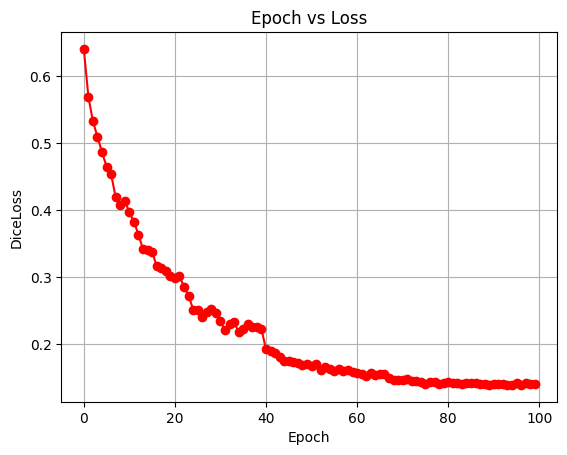

In [32]:
import matplotlib.pyplot as plt

epochs = [item[0] for item in losses]
losses_ = [item[1] for item in losses]

# Plotting
plt.plot(epochs, losses_, color='red', marker='o', linestyle='-')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('DiceLoss')
plt.grid(True)
plt.show()

In [34]:
f1,acc,filenames= predict(model,local_test_loader,device)

Processing prediction_001.png
Processing prediction_002.png
Processing prediction_003.png
Processing prediction_004.png
Processing prediction_005.png
Processing prediction_006.png
Processing prediction_007.png
Processing prediction_008.png
Processing prediction_009.png
Processing prediction_010.png
Processing prediction_011.png
Processing prediction_012.png
Processing prediction_013.png
Processing prediction_014.png
Processing prediction_015.png
Processing prediction_016.png
Processing prediction_017.png
Processing prediction_018.png
Processing prediction_019.png
Processing prediction_020.png
Prediction completed.
F1 Score:  0.8191933721179041
Accuracy:  0.9337771874999999


## Testing and submission

In [35]:
test_image_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [36]:
test_set = ImagesDataset(
    img_dir=TEST_IMAGES,
    image_transform=test_image_transform,
)

In [37]:
test_loader = DataLoader(
    dataset=test_set,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)

In [ ]:
_,_,filenames= predict(model,test_loader,device)

In [39]:
masks_to_submission('submission.csv',*filenames)

In [40]:
torch.save(model.state_dict(), 'modelAug_LF18191.pth')

In [ ]:
#Run this only if you load the model
model= UNet().to(device)
state_dict = torch.load('models/trained_model_100ep_10batch.pth', map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Set the model in evaluation mode
model.eval()

f1_scores = list()
accuracy_scores = list()

# Switch off autograd
with torch.no_grad():
    # Loop over the dataset
    for i, (data, target) in enumerate(local_test_loader):
        filename = create_filename(len(local_test_loader),i)
        print(f'Processing {filename}')

        # Send the input to the device
        data = data.to(device)
        if target.dim() != 1:
            target = target.to(device)

        # Make the predictions
        output = model(data)

        # Get labels
        output = get_label(output, FOREGROUND_TRESHOLD)

        if target.dim() != 1:
            target= target.to(device)
            target = get_label(target, FOREGROUND_TRESHOLD)
            accuracy = accuracy_(target, output)
            f1 = f1_(target, output)
            accuracy_scores.append(accuracy)
            f1_scores.append(f1)

        # Save mask
        if not os.path.exists(LOCAL_PREDICTIONS_PATH):
            os.makedirs(LOCAL_PREDICTIONS_PATH)
        output_path = os.path.join(LOCAL_PREDICTIONS_PATH, filename)
        save_prediction(output, output_path)
        prediction_filnames.append(output_path)

# Print a message after processing all images
print('Prediction completed.')


In [ ]:
process_images('predictions/','improved_white')

In [ ]:
image_names = [f for f in os.listdir('improved_more') if f.endswith(('.png', '.jpg', '.jpeg'))]


In [ ]:
filenames= list()
for name in image_names:
    new_name = os.path.join('improved_more', name)
    filenames.append(new_name)


In [ ]:
from helper import *
masks_to_submission('submission.csv', *filenames)

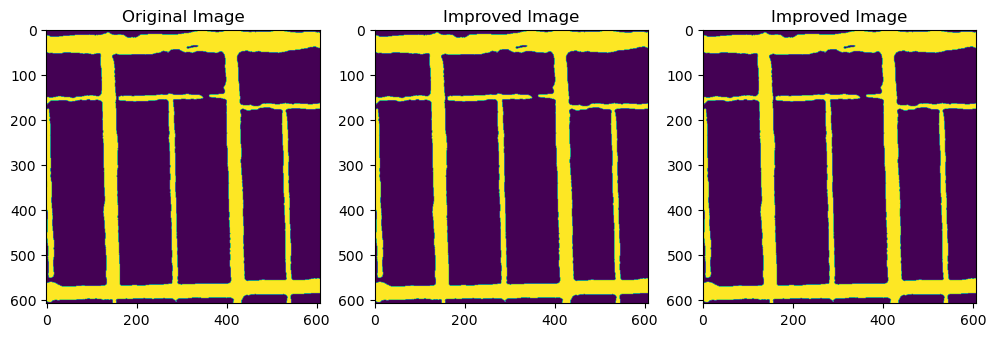

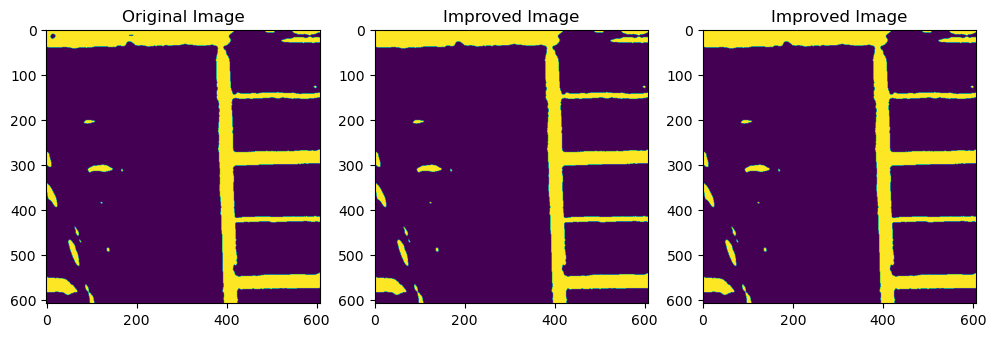

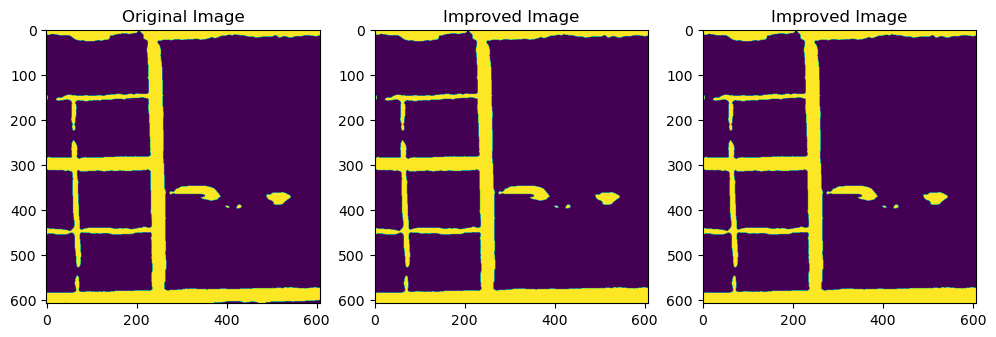

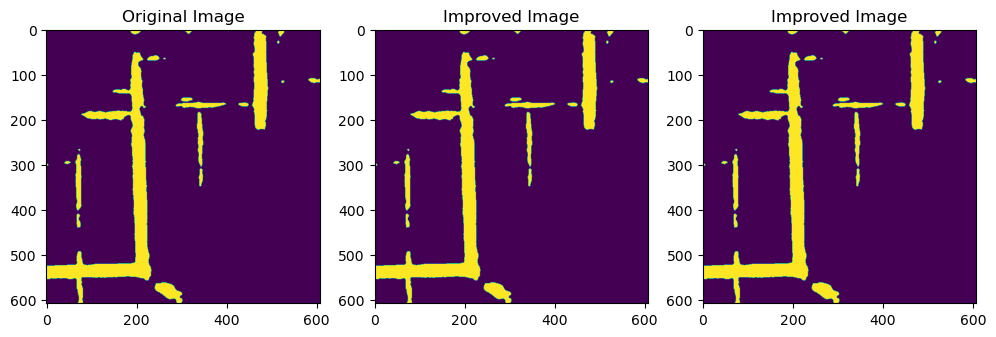

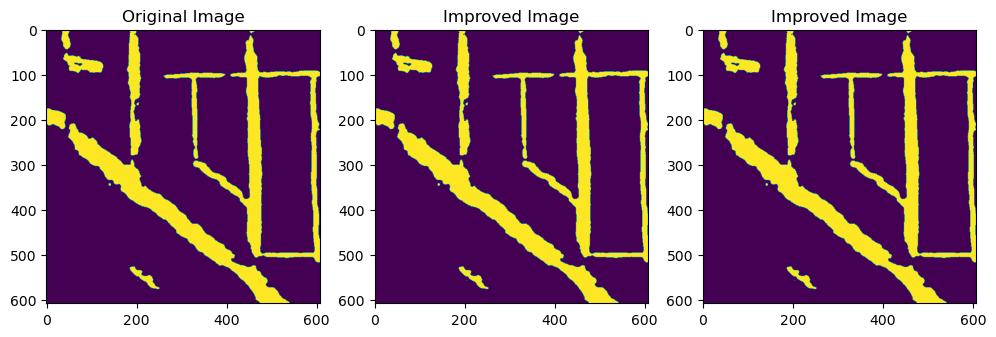

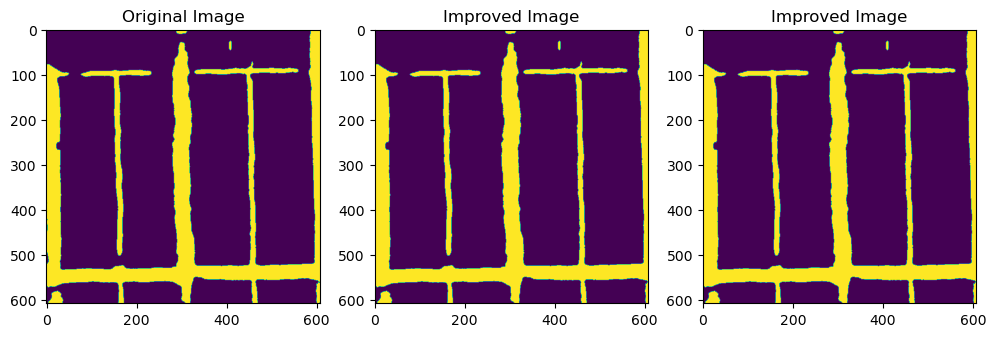

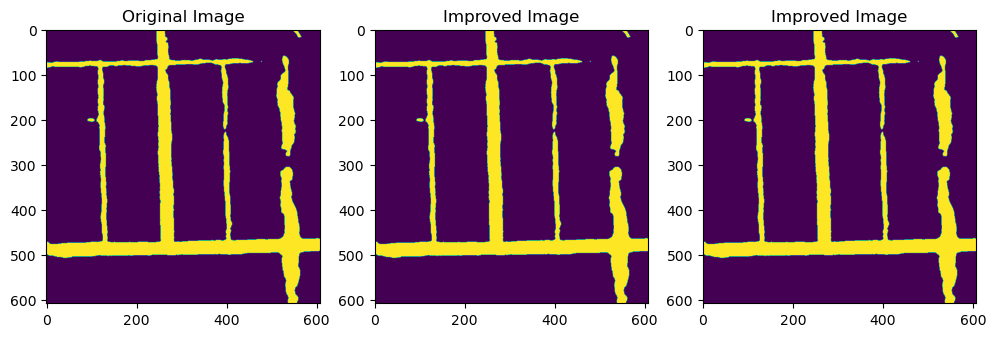

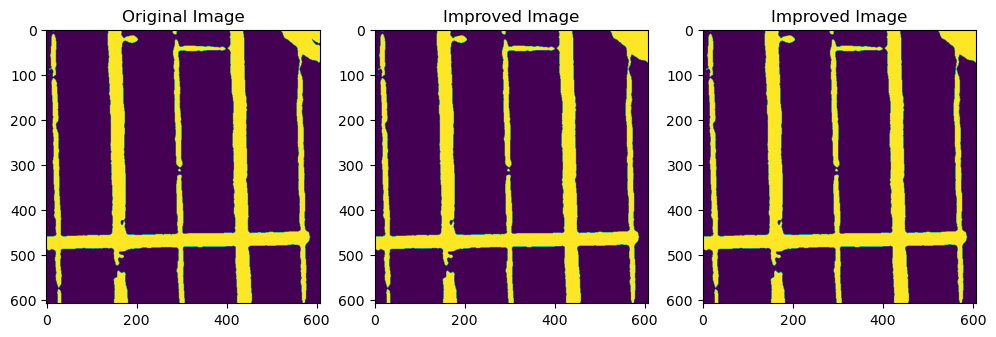

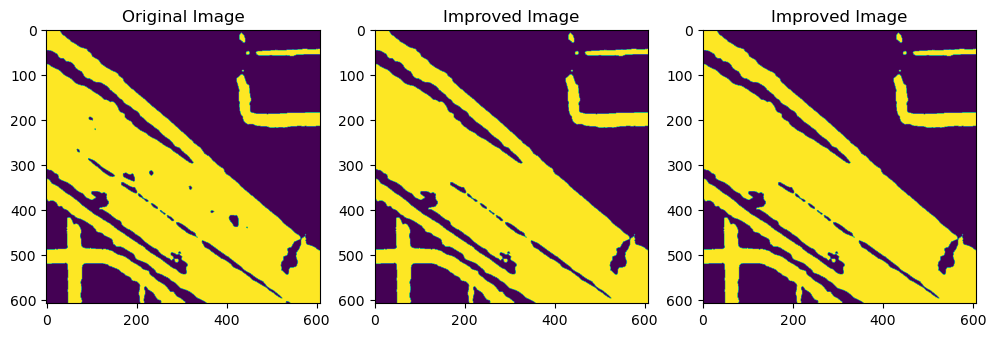

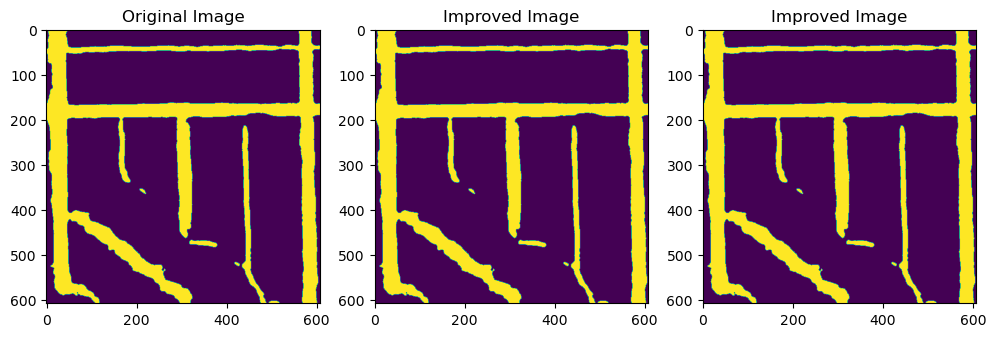

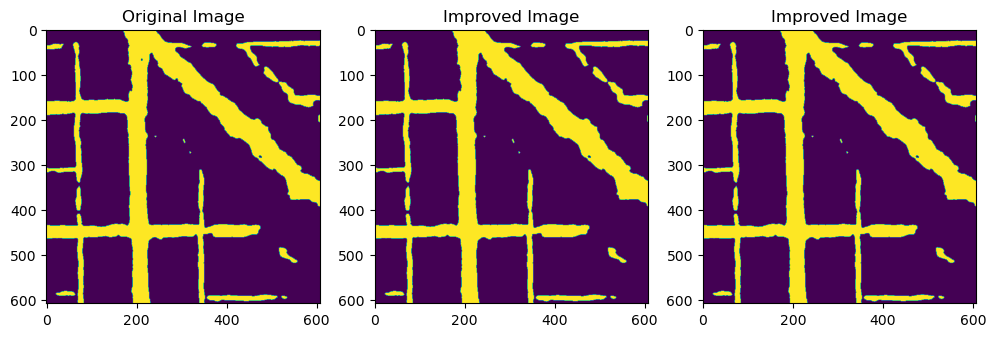

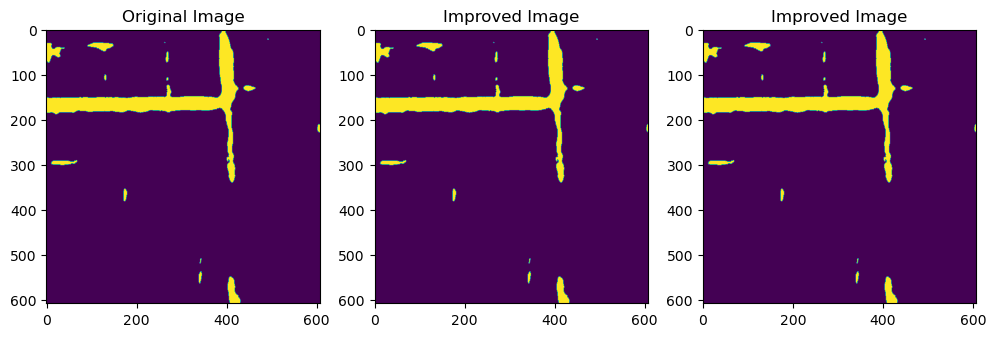

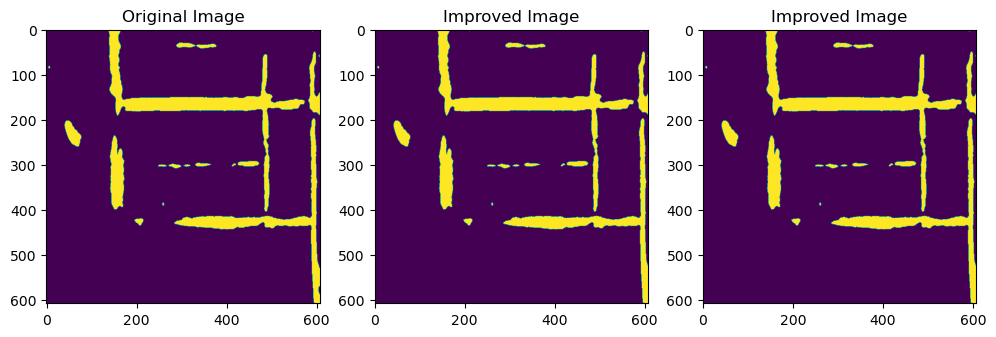

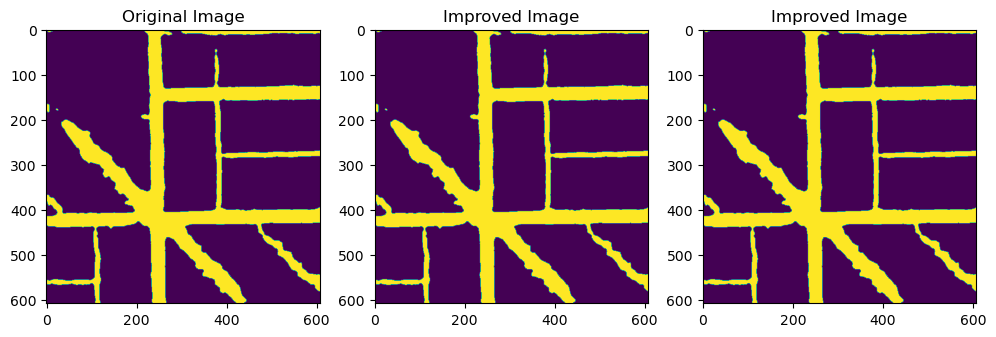

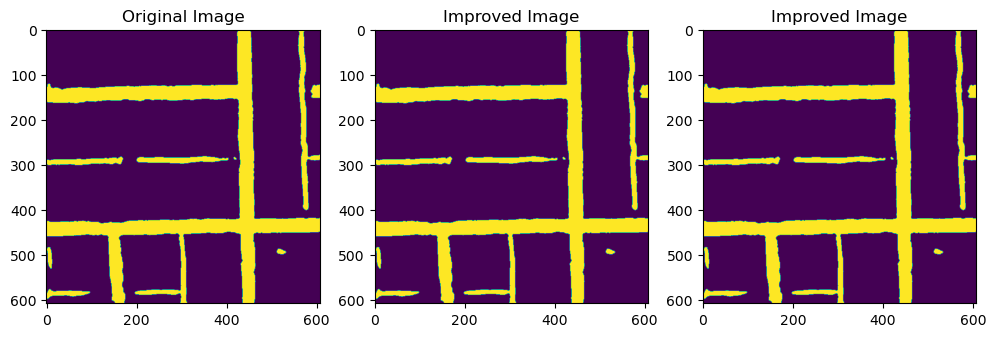

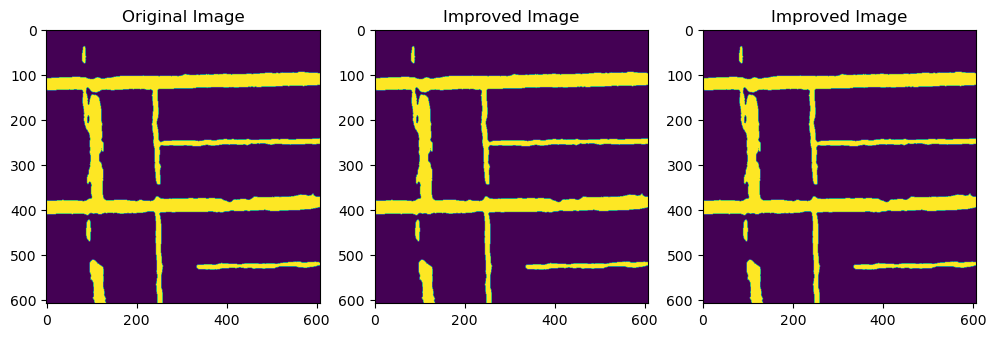

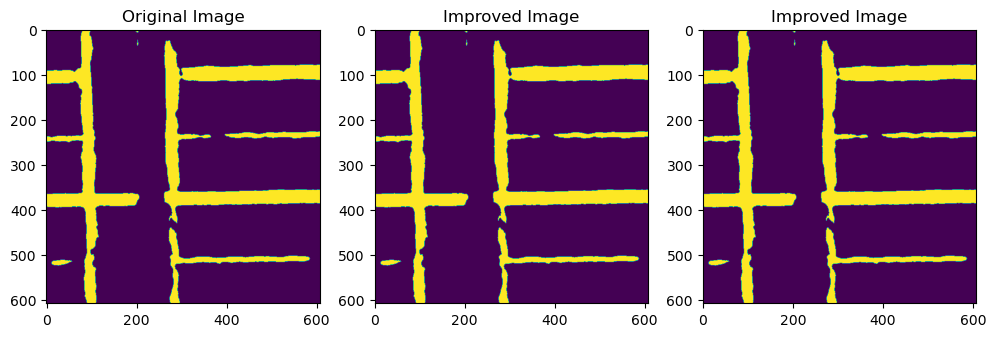

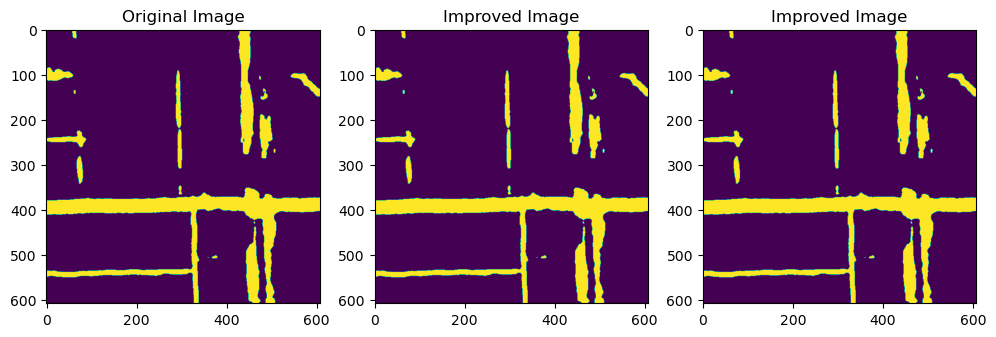

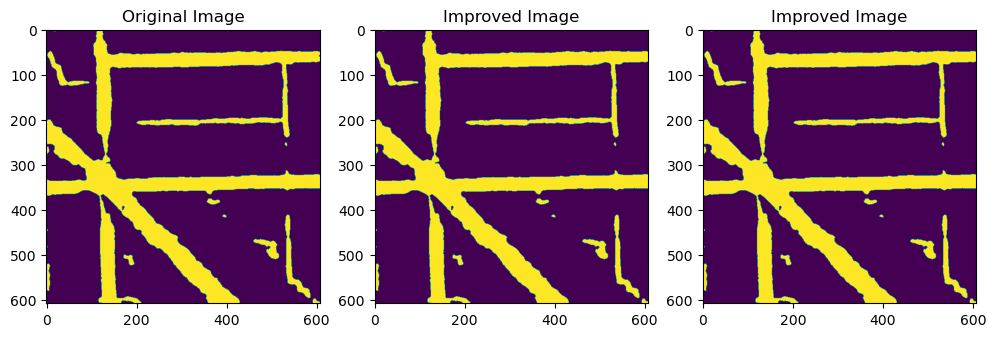

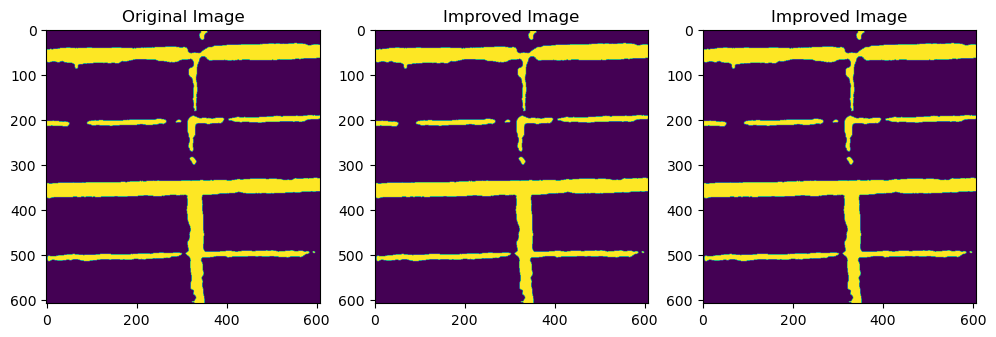

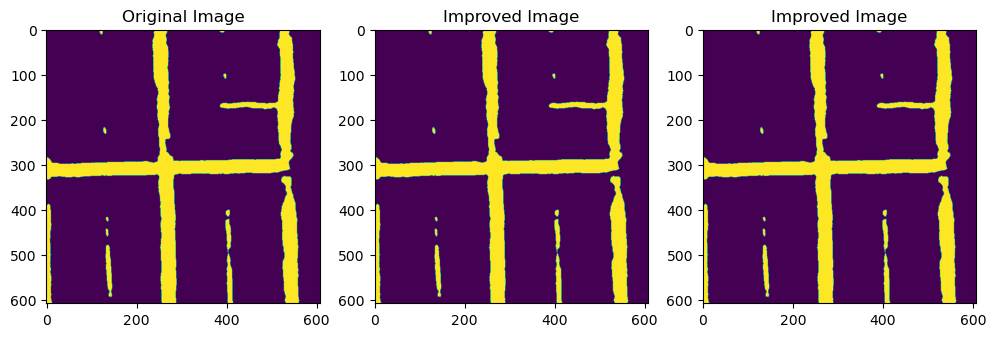

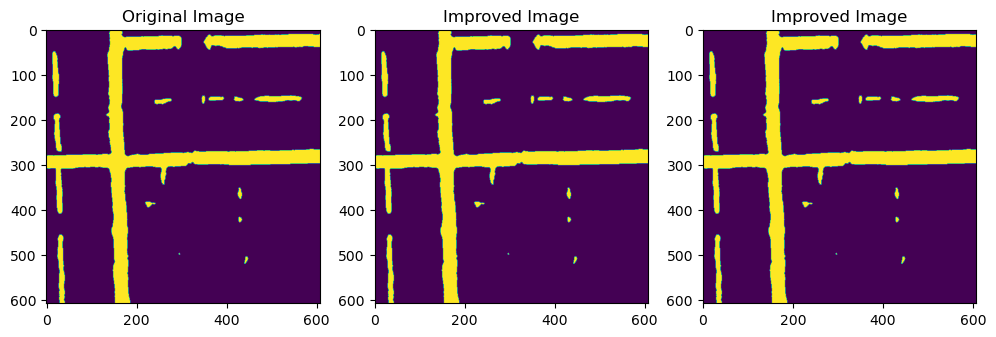

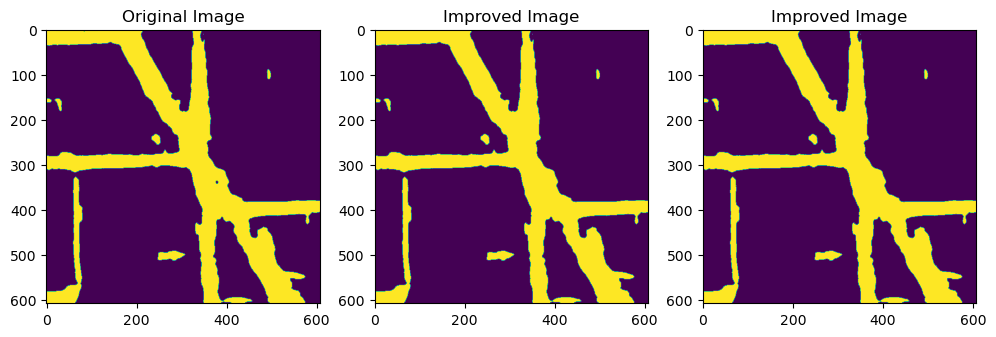

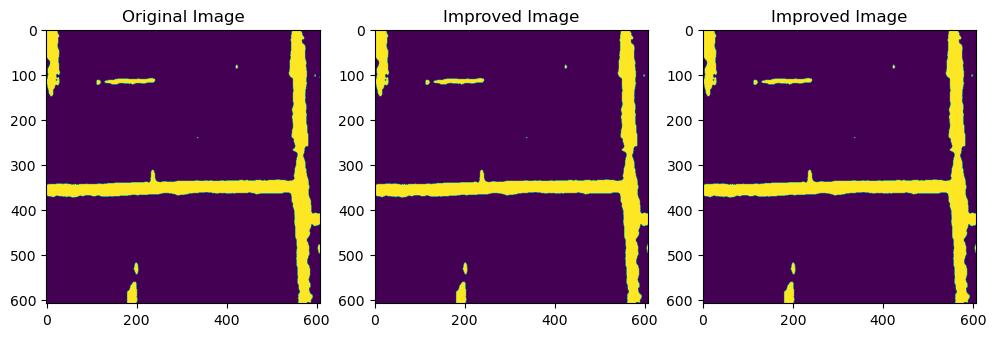

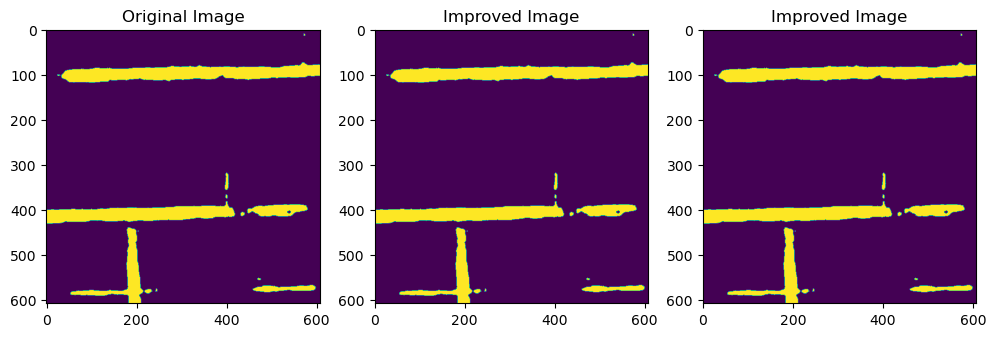

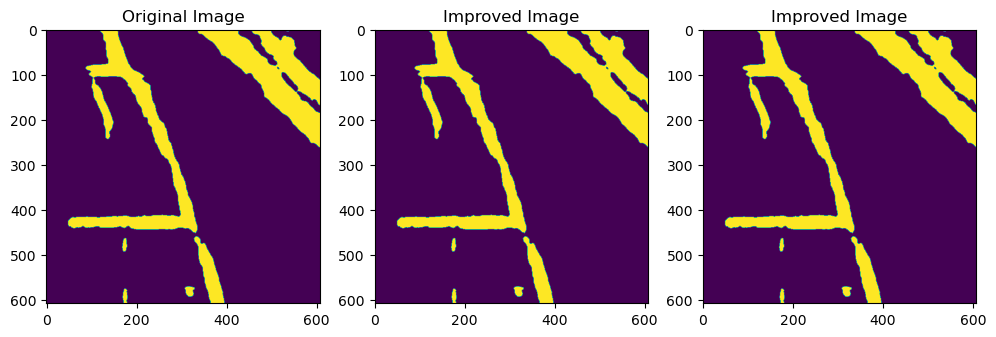

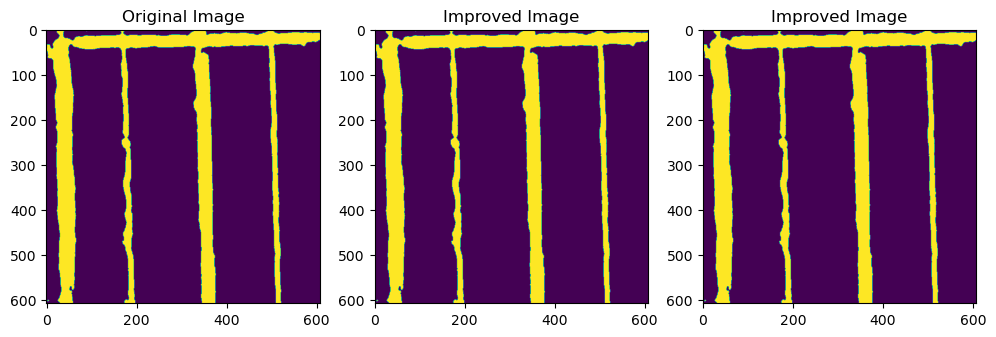

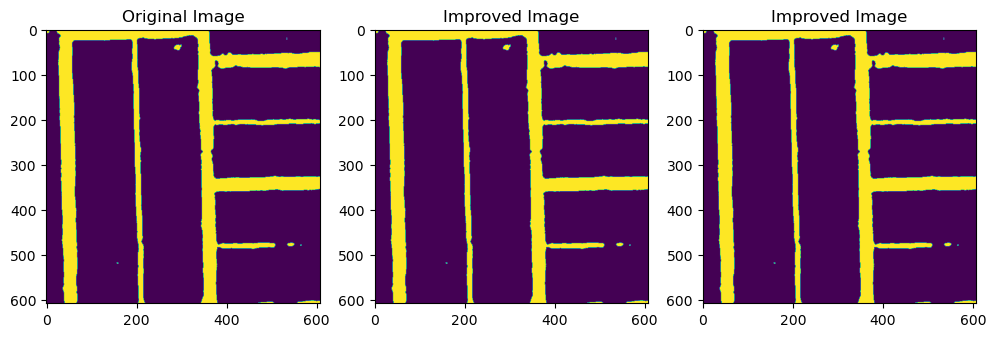

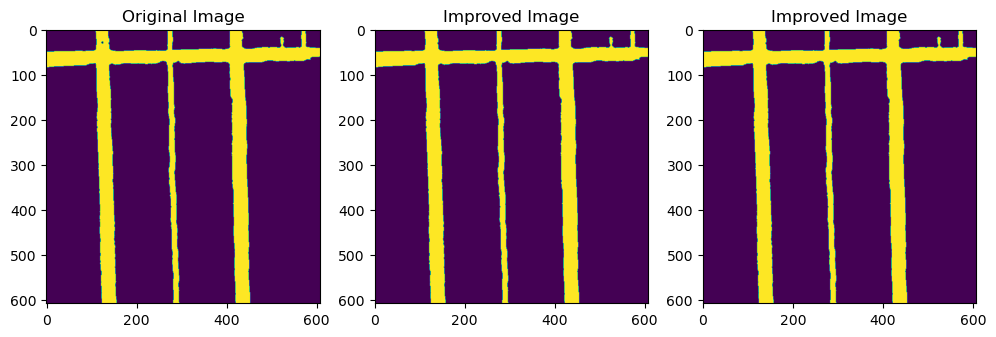

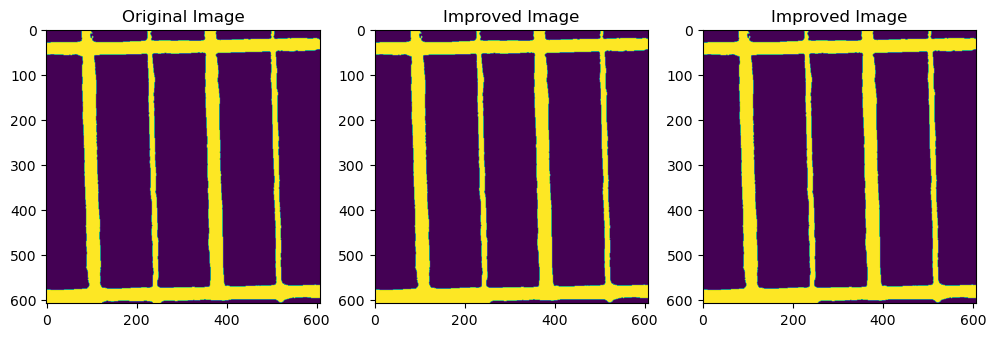

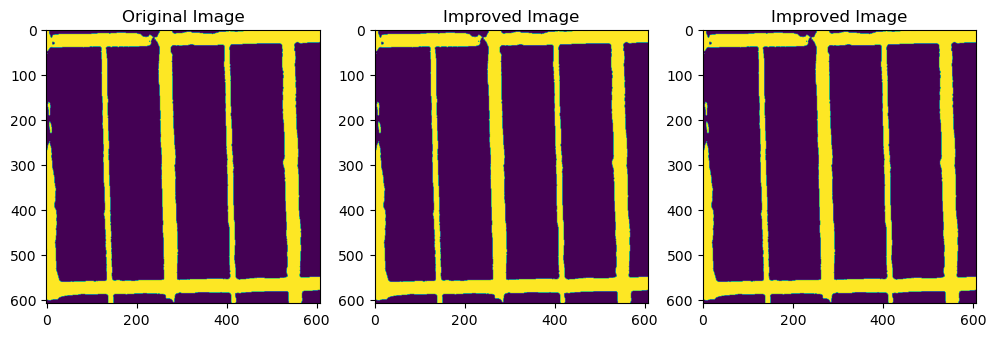

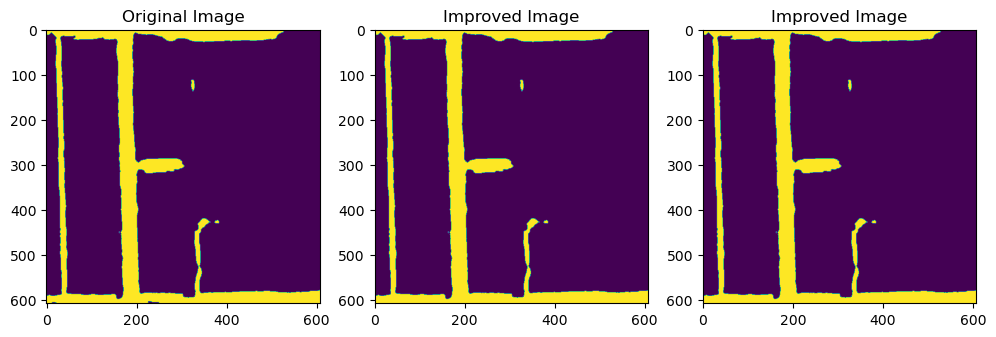

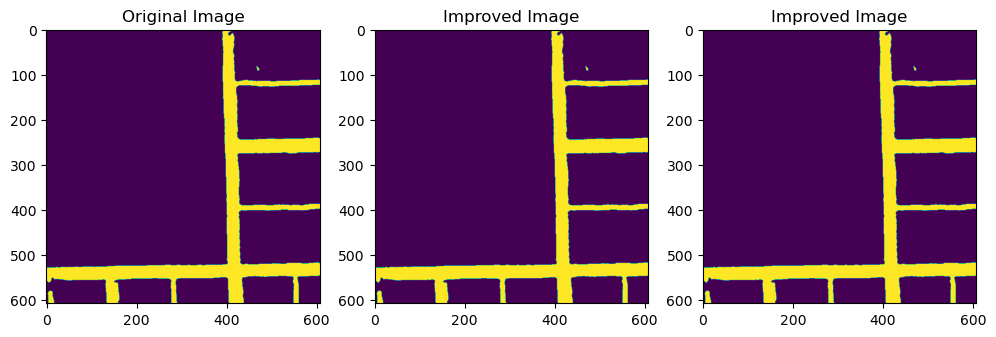

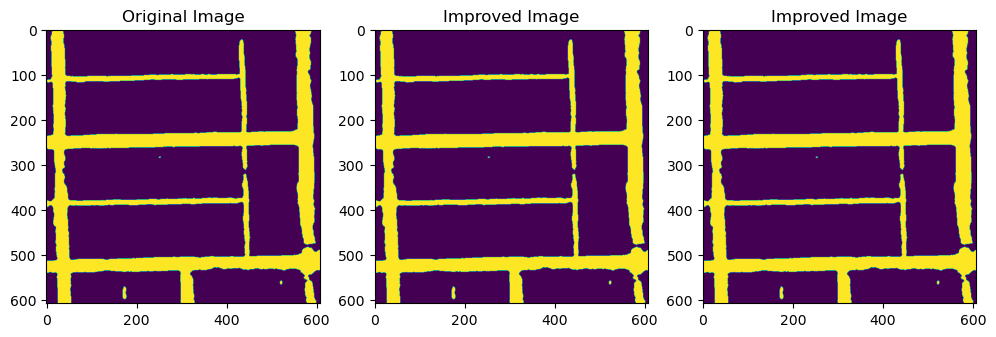

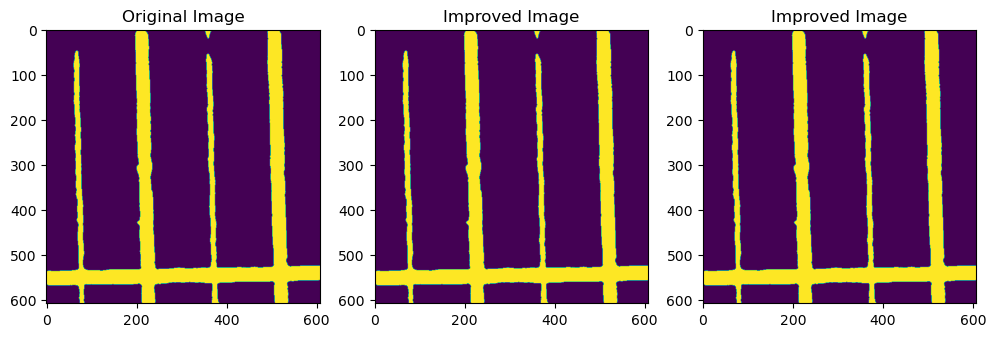

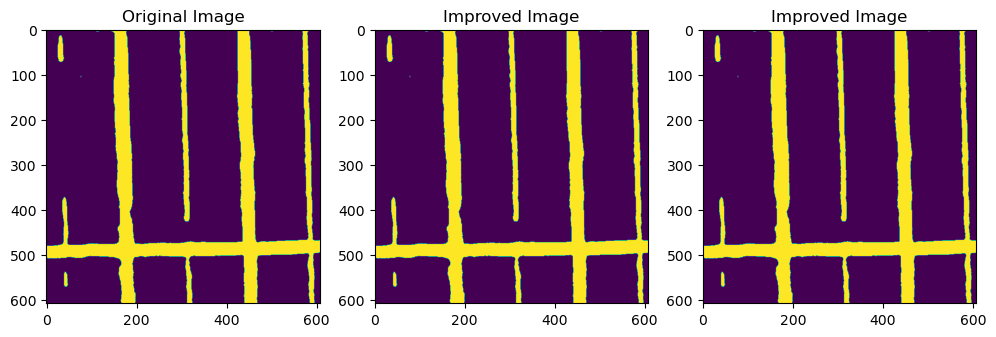

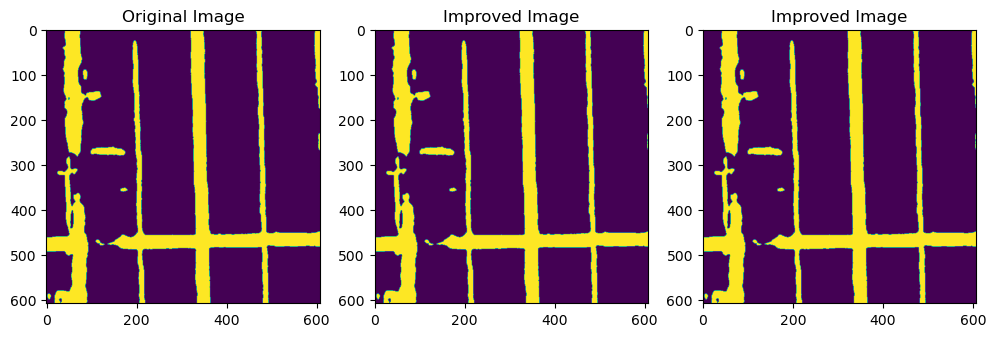

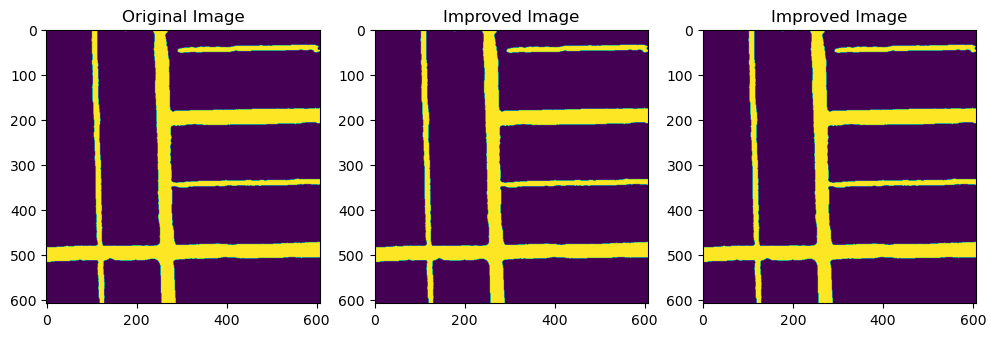

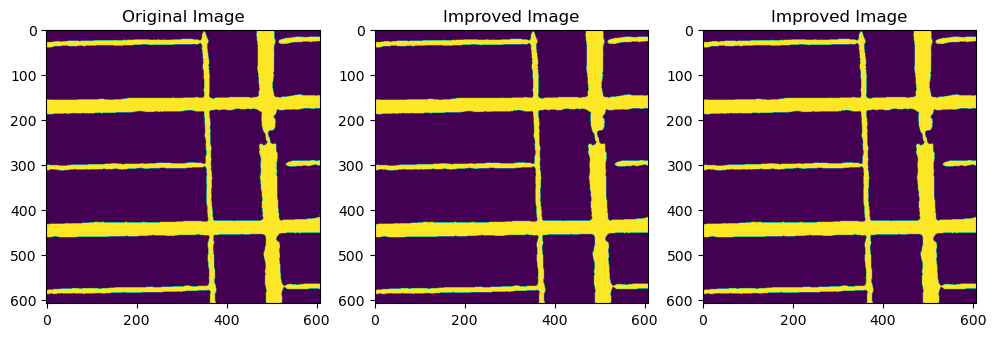

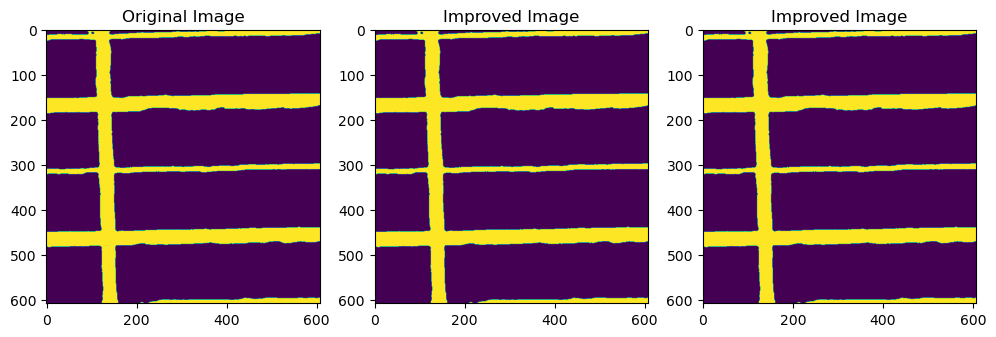

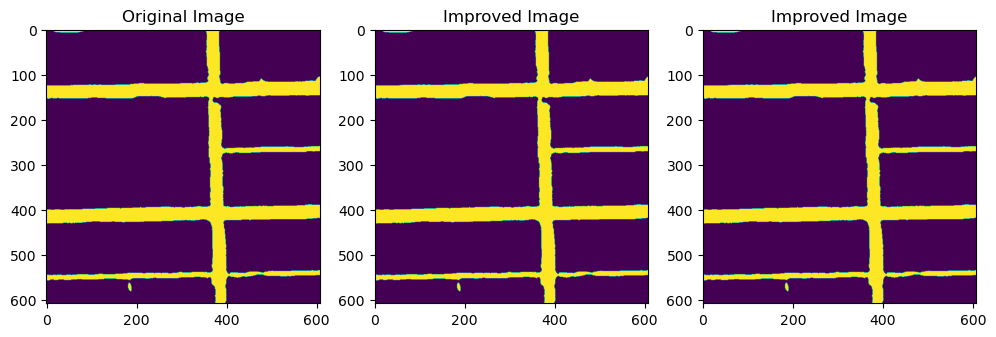

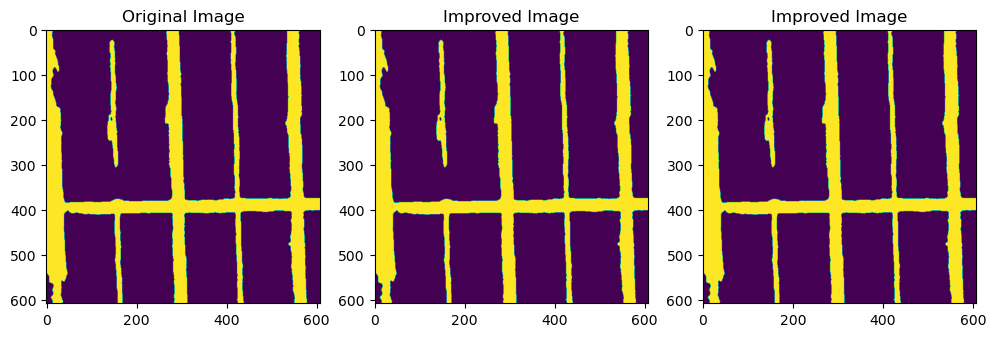

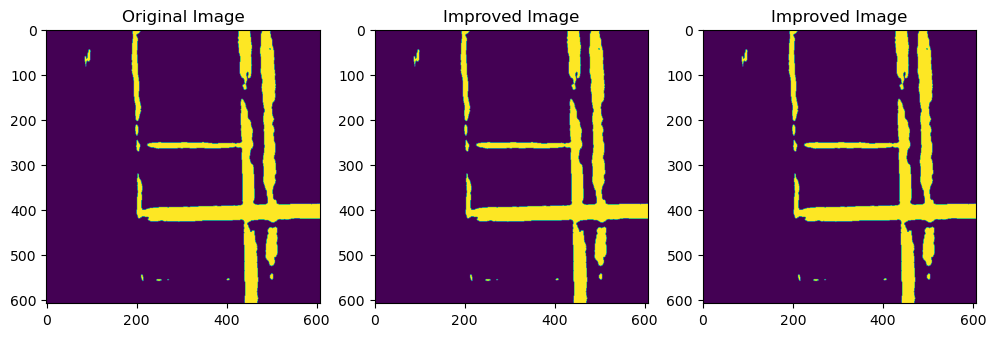

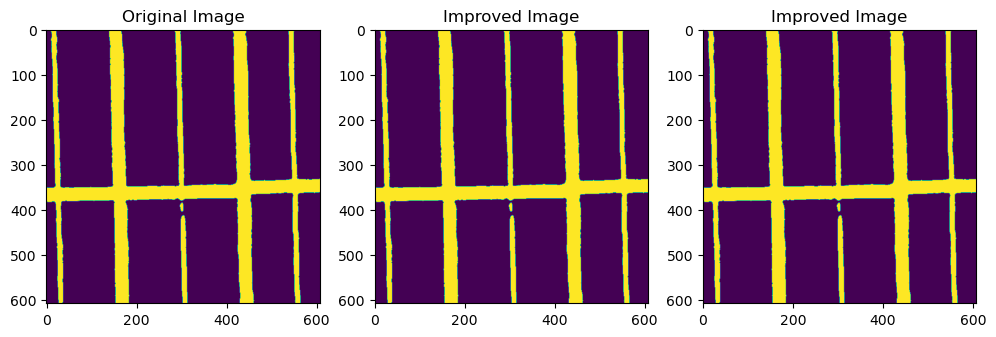

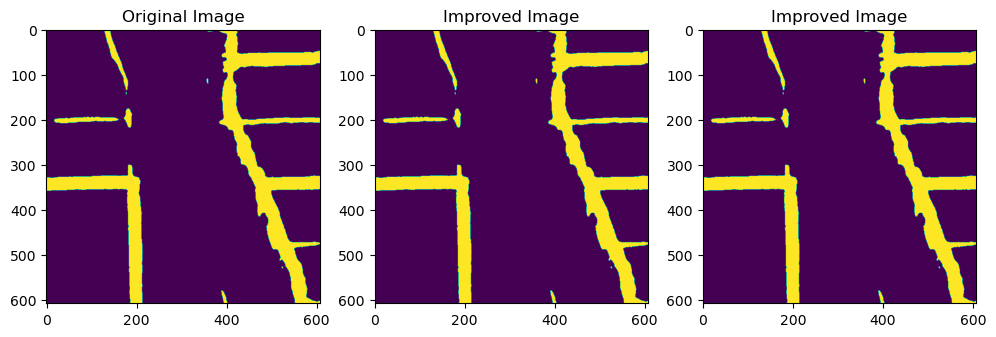

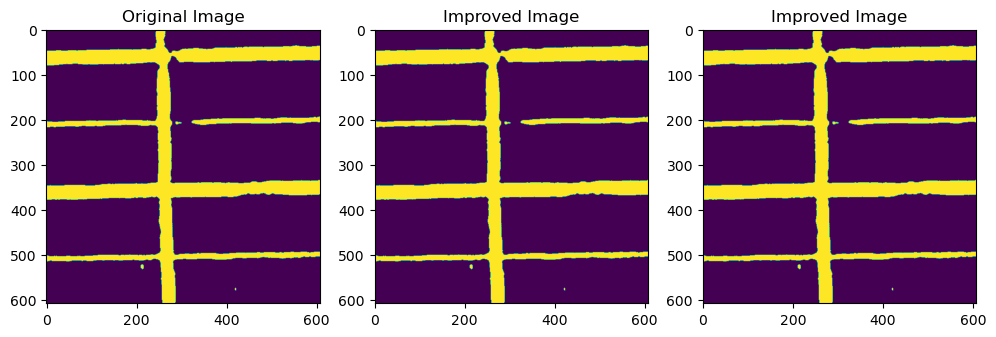

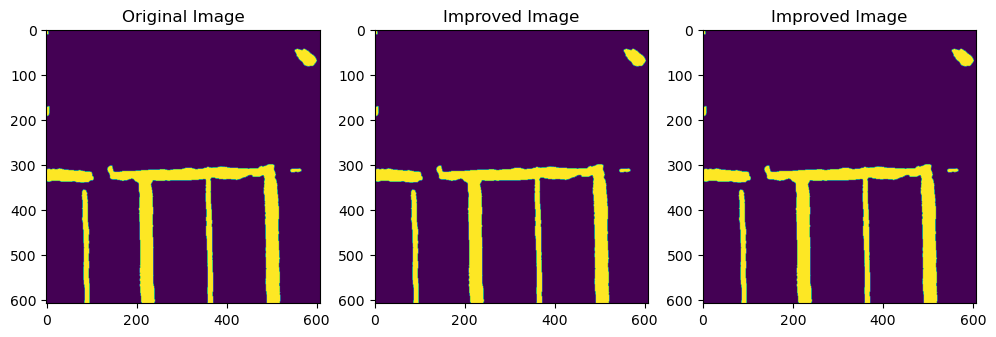

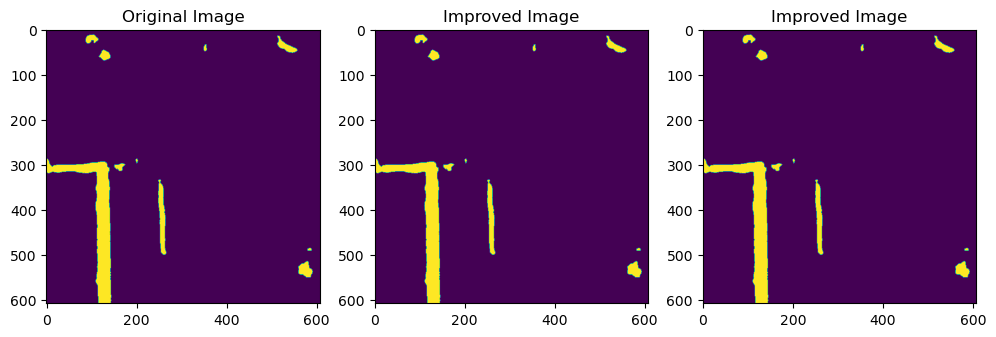

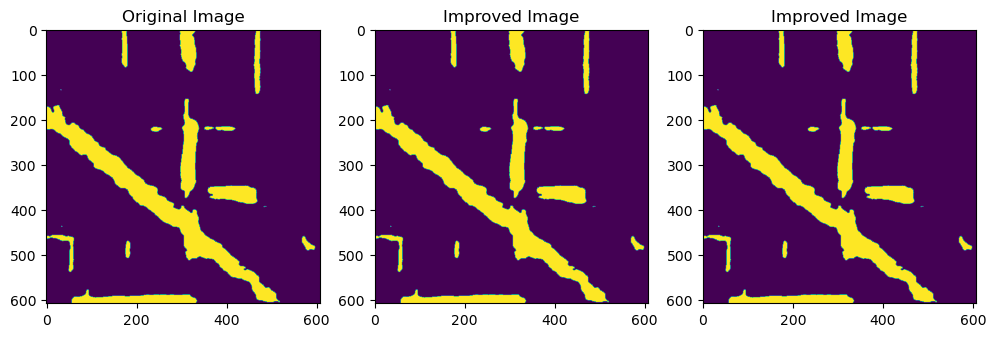

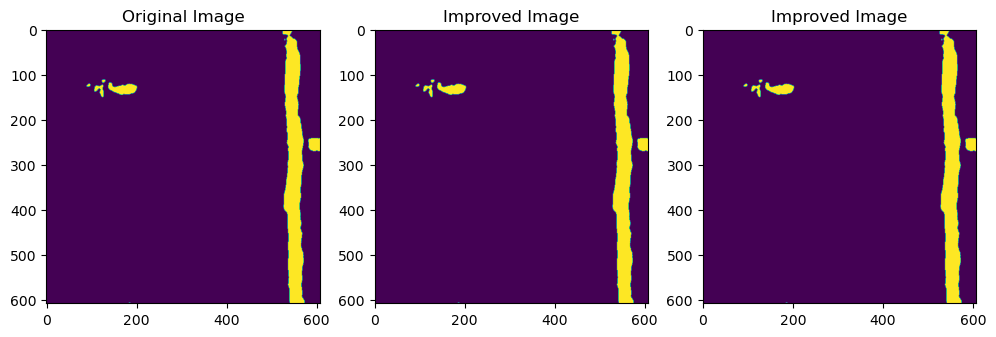

In [ ]:
import matplotlib.pyplot as plt

# Plot each pair of images
for image_file in image_names:
    # Load the original image from 'predictions' folder
    predictions_path = os.path.join('predictions/', image_file)
    improved_preds_path = os.path.join('improved_preds/', image_file)
    improved_more_path = os.path.join('improved_more/', image_file)

    original_image = Image.open(predictions_path)
    improved_image = Image.open(improved_preds_path)
    improved_more= Image.open(improved_more_path)

    # Plot the images side by side
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(improved_image)
    plt.title('Improved Image')

    plt.subplot(1, 3, 3)
    plt.imshow(improved_image)
    plt.title('Improved Image')

    plt.show()
